# E-COMMERCE SALES & CUSTOMER ANALYSIS

Business Problem: Analyze sales trends, customer behavior, and delivery 
performance to identify revenue drivers and operational issues.

### 1. IMPORT LIBRARIES

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define folders
images_folder = "../images"
csv_folder = "../"

# Creating folders if they do not exist
os.makedirs(images_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)

print("Libraries imported successfully!!")

Libraries imported successfully!!


### 2. LOADING DATASETS

In [26]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

data_path = "C:/Users\Akhilesh/Akhil_Jupyter_Notebook/Projects/Data Analytics/Full Data Analysis Projects/E-Commerce Sales Analysis/data/"

# Loading all 9 CSV files
customers = pd.read_csv(data_path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(data_path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(data_path + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(data_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(data_path + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(data_path + 'olist_orders_dataset.csv')
products = pd.read_csv(data_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(data_path + 'olist_sellers_dataset.csv')
category_translation = pd.read_csv(data_path + 'product_category_name_translation.csv')

print(f"--> Customers: {customers.shape}")
print(f"--> Orders: {orders.shape}")
print(f"--> Order Items: {order_items.shape}")
print(f"--> Products: {products.shape}")
print(f"--> Payments: {order_payments.shape}")
print(f"--> Reviews: {order_reviews.shape}")
print(f"--> Sellers: {sellers.shape}")
print(f"--> Geolocation: {geolocation.shape}")
print(f"--> Category Translation: {category_translation.shape}")


LOADING DATA
--> Customers: (99441, 5)
--> Orders: (99441, 8)
--> Order Items: (112650, 7)
--> Products: (32951, 9)
--> Payments: (103886, 5)
--> Reviews: (99224, 7)
--> Sellers: (3095, 4)
--> Geolocation: (1000163, 5)
--> Category Translation: (71, 2)


### 3. DATA UNDERSTANDING

In [27]:
print("\n" + "="*80)
print("DATA UNDERSTANDING")
print("="*80)

print("\n--- ORDERS TABLE (Main Table) ---")
print(orders.info())
print("\nFirst few rows:")
print(orders.head())


DATA UNDERSTANDING

--- ORDERS TABLE (Main Table) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

First few rows:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0

In [28]:
print("\n--- KEY RELATIONSHIPS ---")
print("Orders => Customers: customer_id")
print("Orders => Order Items: order_id")
print("Order Items => Products: product_id")
print("Order Items => Sellers: seller_id")
print("Orders => Payments: order_id")
print("Orders => Reviews: order_id")


--- KEY RELATIONSHIPS ---
Orders => Customers: customer_id
Orders => Order Items: order_id
Order Items => Products: product_id
Order Items => Sellers: seller_id
Orders => Payments: order_id
Orders => Reviews: order_id


### 4. DATA CLEANING

In [29]:
print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

# Check missing values
print("\n--- Missing Values ---")
print(f"Orders: {orders.isnull().sum().sum()} missing values")
print(f"Order Items: {order_items.isnull().sum().sum()} missing values")
print(f"Products: {products.isnull().sum().sum()} missing values")
print(f"Reviews: {order_reviews.isnull().sum().sum()} missing values")

# Convert date columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

print("\n--> Date columns converted to datetime")

# Remove cancelled and unavailable orders
print(f"\nOriginal orders: {len(orders)}")
orders_clean = orders[orders['order_status'].isin(['delivered', 'shipped', 'processing'])].copy()
print(f"After removing cancelled/unavailable: {len(orders_clean)}")

# Remove duplicates
print(f"\nDuplicates in customers: {customers.duplicated().sum()}")
print(f"Duplicates in order_items: {order_items.duplicated().sum()}")


DATA CLEANING

--- Missing Values ---
Orders: 4908 missing values
Order Items: 0 missing values
Products: 2448 missing values
Reviews: 145903 missing values

--> Date columns converted to datetime

Original orders: 99441
After removing cancelled/unavailable: 97886

Duplicates in customers: 0
Duplicates in order_items: 0


### 5. FEATURE ENGINEERING

In [30]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Merge products with category translation
products_eng = products.merge(category_translation, 
                               on='product_category_name', 
                               how='left')

# Calculate delivery time (actual - purchase)
orders_clean['delivery_time_days'] = (
    orders_clean['order_delivered_customer_date'] - 
    orders_clean['order_purchase_timestamp']
).dt.days

# Calculate delivery delay (actual - estimated)
orders_clean['delivery_delay_days'] = (
    orders_clean['order_delivered_customer_date'] - 
    orders_clean['order_estimated_delivery_date']
).dt.days

# Extract temporal features
orders_clean['order_month'] = orders_clean['order_purchase_timestamp'].dt.to_period('M')
orders_clean['order_year'] = orders_clean['order_purchase_timestamp'].dt.year
orders_clean['order_month_name'] = orders_clean['order_purchase_timestamp'].dt.month_name()
orders_clean['order_day_of_week'] = orders_clean['order_purchase_timestamp'].dt.day_name()
orders_clean['order_hour'] = orders_clean['order_purchase_timestamp'].dt.hour

print("--> Delivery time calculated")
print("--> Temporal features created")


FEATURE ENGINEERING
--> Delivery time calculated
--> Temporal features created


### 6. CREATE MASTER DATASET

In [31]:
print("\n" + "="*80)
print("CREATING MASTER DATASET")
print("="*80)

# Merge all relevant tables
df = orders_clean.merge(customers, on='customer_id', how='left')
df = df.merge(order_items, on='order_id', how='left')
df = df.merge(products_eng, on='product_id', how='left')
df = df.merge(order_payments, on='order_id', how='left')
df = df.merge(order_reviews[['order_id', 'review_score']], on='order_id', how='left')

print(f"Master dataset shape: {df.shape}")
print(f"Date range: {df['order_purchase_timestamp'].min()} to {df['order_purchase_timestamp'].max()}")


CREATING MASTER DATASET
Master dataset shape: (117355, 39)
Date range: 2016-09-04 21:15:19 to 2018-09-03 09:06:57


### 7. EXPLORATORY DATA ANALYSIS - SALES TRENDS


SALES ANALYSIS


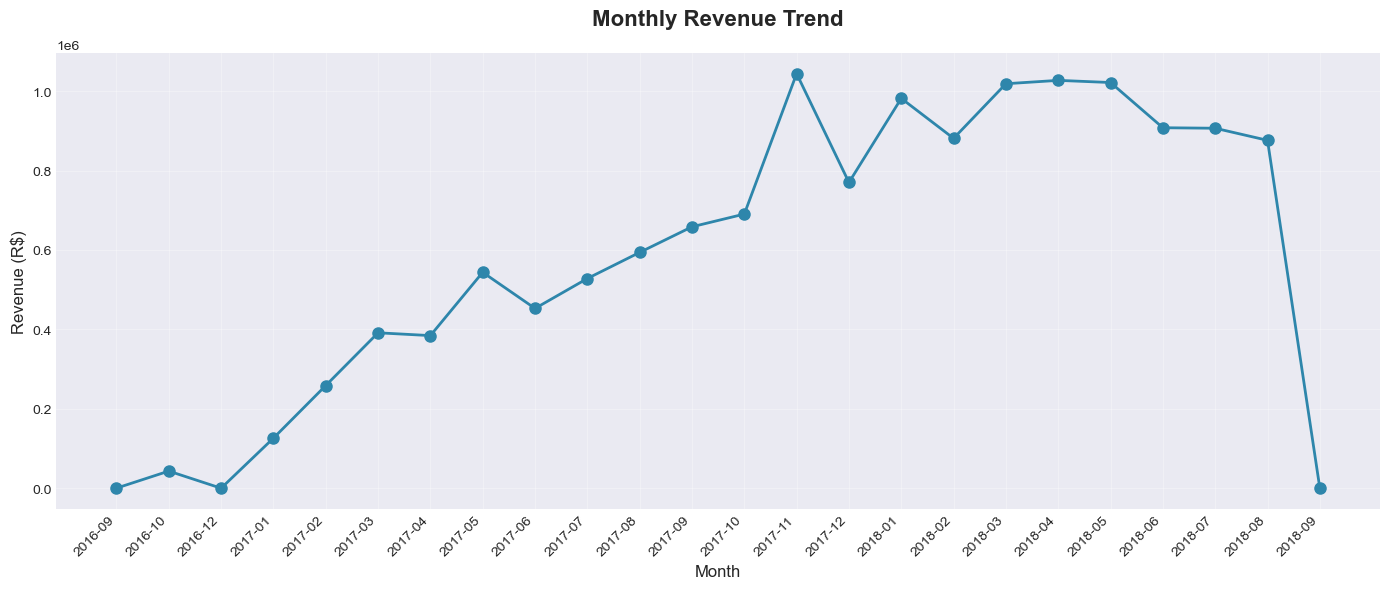

Total Revenue: R$ 14,106,254.50
Average Order Value: R$ 144.11


In [32]:
print("\n" + "="*80)
print("SALES ANALYSIS")
print("="*80)

# Monthly revenue trend
monthly_revenue = df.groupby('order_month')['price'].sum().reset_index()
monthly_revenue['order_month'] = monthly_revenue['order_month'].astype(str)

plt.figure(figsize=(14, 6))
plt.plot(monthly_revenue['order_month'], monthly_revenue['price'], 
         marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.title('Monthly Revenue Trend', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (R$)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(images_folder,'monthly_revenue_trend.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Total Revenue: R$ {df['price'].sum():,.2f}")
print(f"Average Order Value: R$ {df.groupby('order_id')['price'].sum().mean():,.2f}")

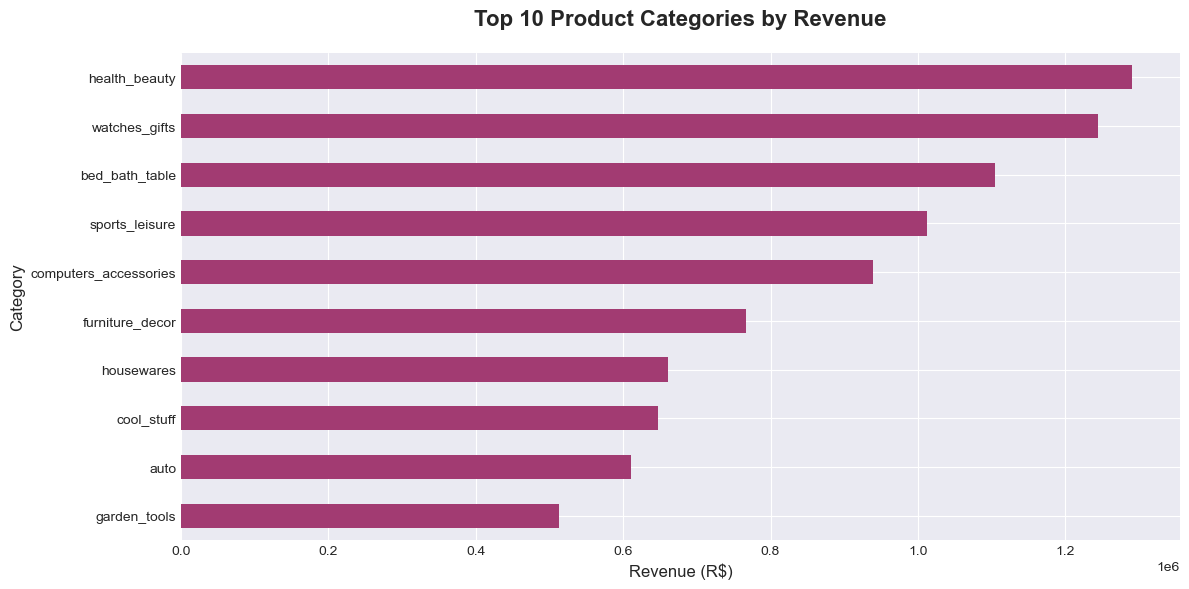

In [33]:
# Top 10 product categories by revenue
top_categories = df.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_categories.plot(kind='barh', color='#A23B72')
plt.title('Top 10 Product Categories by Revenue', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Revenue (R$)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(images_folder, 'top_categories_revenue.png'), dpi=300, bbox_inches='tight')
plt.show()

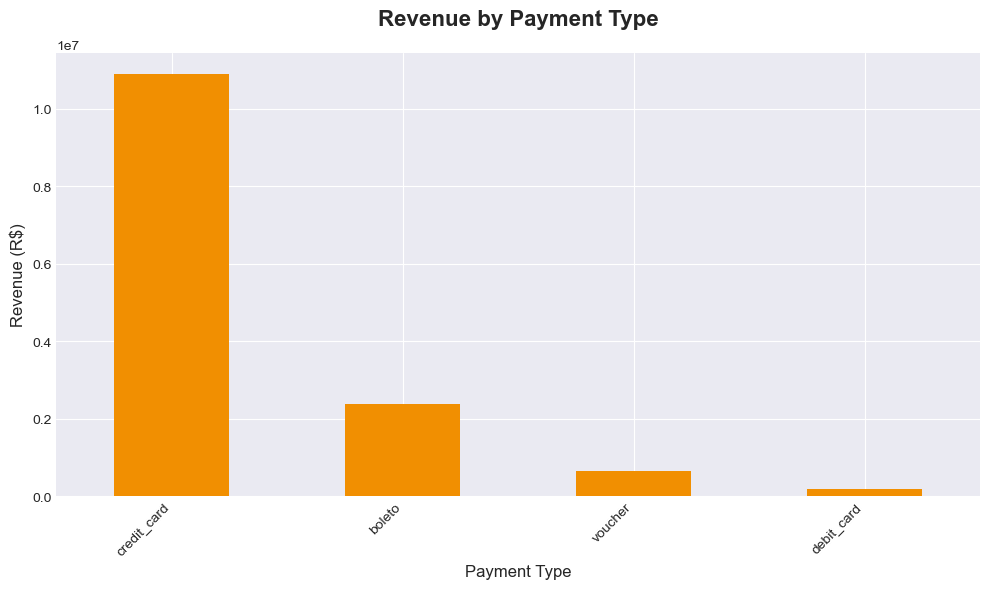

In [34]:
# Revenue by payment type
payment_revenue = df.groupby('payment_type')['price'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
payment_revenue.plot(kind='bar', color='#F18F01')
plt.title('Revenue by Payment Type', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Payment Type', fontsize=12)
plt.ylabel('Revenue (R$)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(images_folder,'payment_type_revenue.png'), dpi=300, bbox_inches='tight')
plt.show()

### 8. CUSTOMER ANALYSIS

In [35]:
print("\n" + "="*80)
print("CUSTOMER ANALYSIS")
print("="*80)

# Customer purchase frequency
customer_orders = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_orders.columns = ['customer_unique_id', 'order_count']

purchase_distribution = customer_orders['order_count'].value_counts().sort_index()

print("\n--- Purchase Frequency ---")
print(f"One-time customers: {(customer_orders['order_count'] == 1).sum()} ({(customer_orders['order_count'] == 1).sum() / len(customer_orders) * 100:.1f}%)")
print(f"Repeat customers: {(customer_orders['order_count'] > 1).sum()} ({(customer_orders['order_count'] > 1).sum() / len(customer_orders) * 100:.1f}%)")


CUSTOMER ANALYSIS

--- Purchase Frequency ---
One-time customers: 91814 (97.0%)
Repeat customers: 2872 (3.0%)


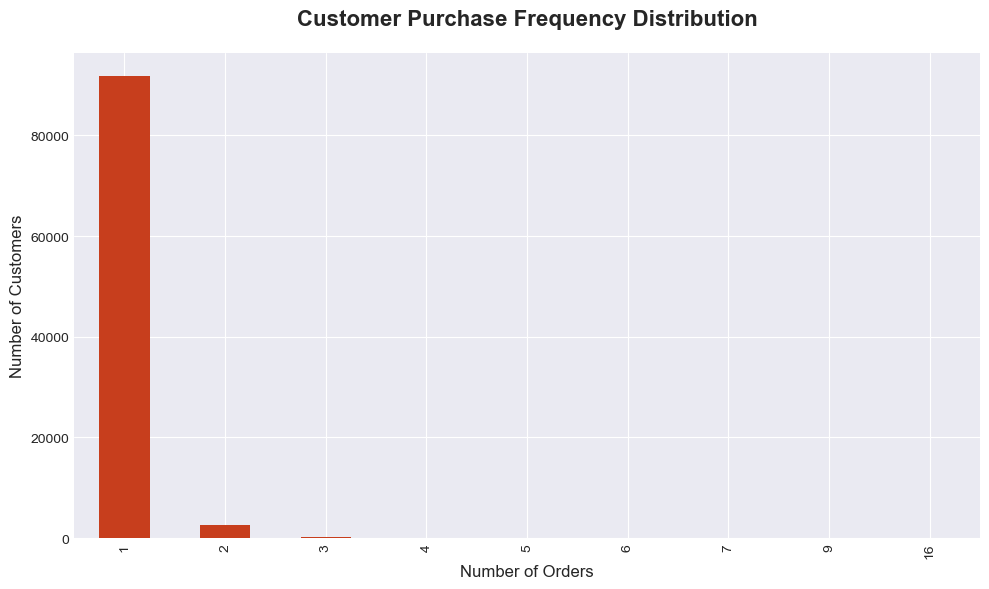

In [36]:
plt.figure(figsize=(10, 6))
purchase_distribution.head(10).plot(kind='bar', color='#C73E1D')
plt.title('Customer Purchase Frequency Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(images_folder,'purchase_frequency.png'), dpi=300, bbox_inches='tight')
plt.show()

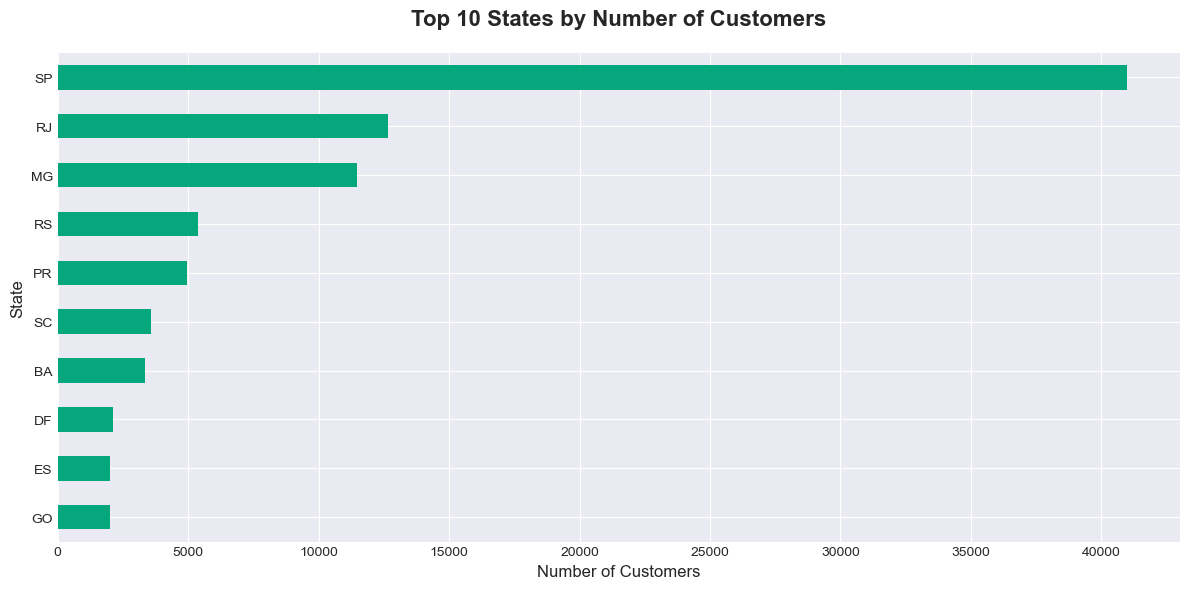

In [37]:
# Top 10 states by number of customers
state_customers = df.groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
state_customers.plot(kind='barh', color='#06A77D')
plt.title('Top 10 States by Number of Customers', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(images_folder,'top_states_customers.png'), dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# RFM Analysis basics
current_date = df['order_purchase_timestamp'].max()
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Recency
    'order_id': 'nunique',  # Frequency
    'price': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

print("\n--- RFM Analysis Summary ---")
print(f"Average Recency: {rfm['recency'].mean():.0f} days")
print(f"Average Frequency: {rfm['frequency'].mean():.2f} orders")
print(f"Average Monetary Value: R$ {rfm['monetary'].mean():,.2f}")


--- RFM Analysis Summary ---
Average Recency: 242 days
Average Frequency: 1.03 orders
Average Monetary Value: R$ 148.98


### 9. DELIVERY PERFORMANCE ANALYSIS

In [39]:
print("\n" + "="*80)
print("DELIVERY PERFORMANCE ANALYSIS")
print("="*80)

# Delivery time analysis
delivery_data = orders_clean[orders_clean['delivery_time_days'].notna()].copy()

print(f"\nAverage Delivery Time: {delivery_data['delivery_time_days'].mean():.1f} days")
print(f"Median Delivery Time: {delivery_data['delivery_time_days'].median():.1f} days")


DELIVERY PERFORMANCE ANALYSIS

Average Delivery Time: 12.1 days
Median Delivery Time: 10.0 days


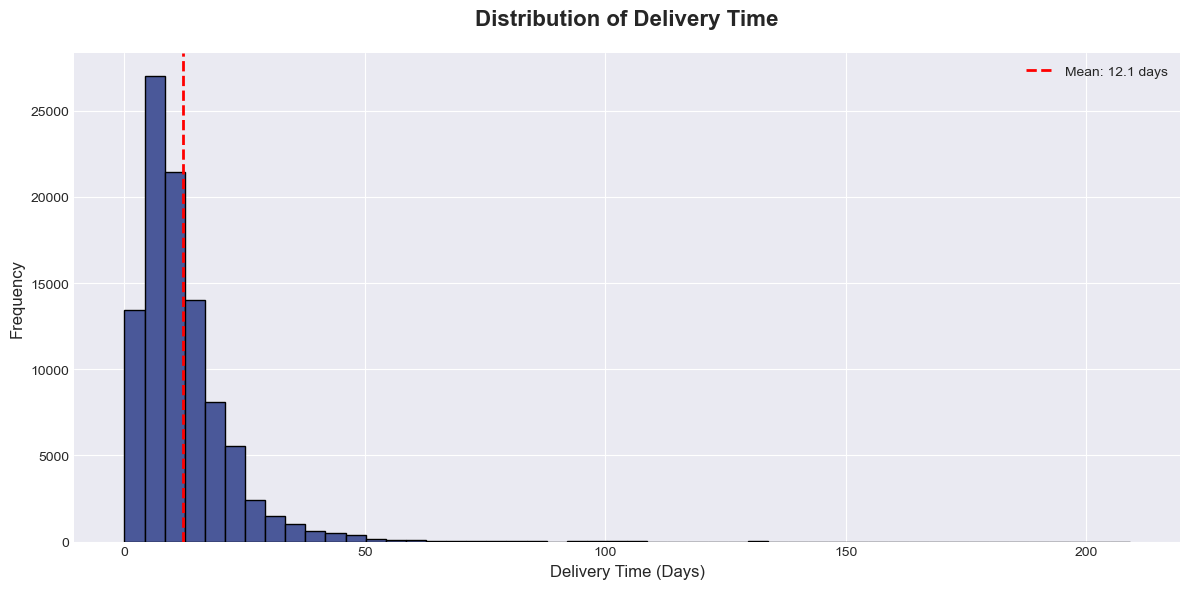

In [40]:
plt.figure(figsize=(12, 6))
plt.hist(delivery_data['delivery_time_days'], bins=50, color='#4A5899', edgecolor='black')
plt.title('Distribution of Delivery Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Delivery Time (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(delivery_data['delivery_time_days'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f"Mean: {delivery_data['delivery_time_days'].mean():.1f} days")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(images_folder,'delivery_time_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# Delivery delay analysis
delay_data = delivery_data[delivery_data['delivery_delay_days'].notna()].copy()
on_time = (delay_data['delivery_delay_days'] <= 0).sum()
delayed = (delay_data['delivery_delay_days'] > 0).sum()

print(f"\nOn-time deliveries: {on_time} ({on_time/len(delay_data)*100:.1f}%)")
print(f"Delayed deliveries: {delayed} ({delayed/len(delay_data)*100:.1f}%)")


On-time deliveries: 89936 (93.2%)
Delayed deliveries: 6534 (6.8%)


In [42]:
# Ensuring customer_state exists in delivery_data
if 'customer_state' not in delivery_data.columns:
    delivery_data = delivery_data.merge(
        df[['order_id', 'customer_state']], 
        on='order_id', 
        how='left'
    )
    
# Delivery delay by state (top 10 states by orders)
top_states = df['customer_state'].value_counts().head(10).index

state_delay = (
    delivery_data[
        (delivery_data['customer_state'].isin(top_states)) &
        (delivery_data['delivery_delay_days'].notna())
    ]
    .groupby('customer_state')['delivery_delay_days']
    .mean()
    .sort_values()
)

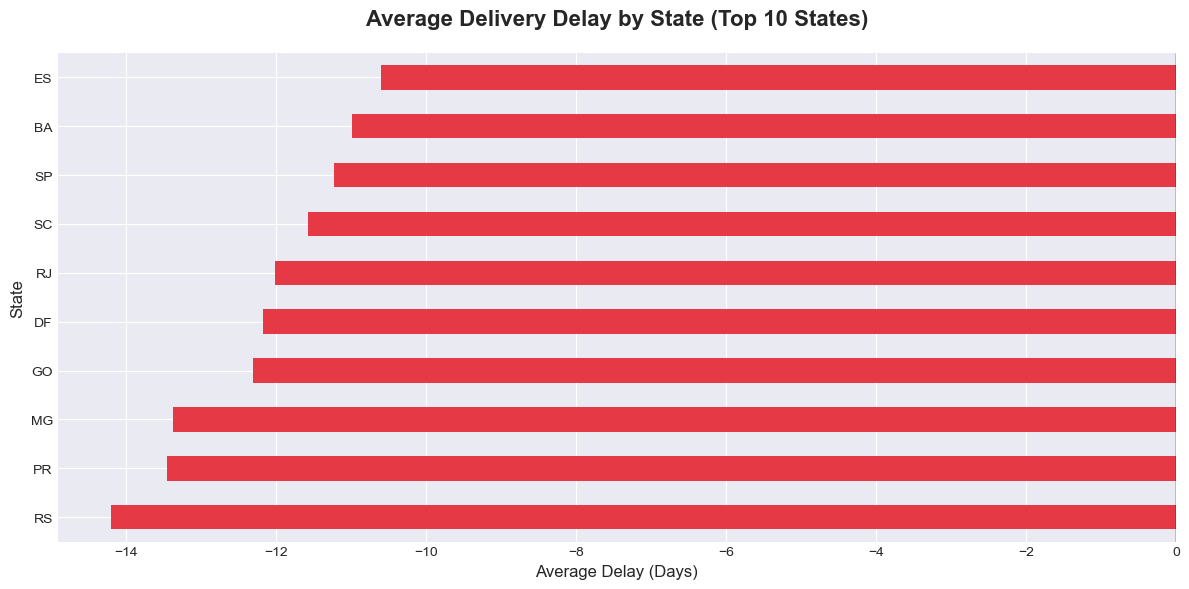

In [43]:
plt.figure(figsize=(12, 6))
state_delay.plot(kind='barh', color='#E63946')
plt.title('Average Delivery Delay by State (Top 10 States)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Average Delay (Days)', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.savefig(os.path.join(images_folder,'delivery_delay_by_state.png'), dpi=300, bbox_inches='tight')
plt.show()

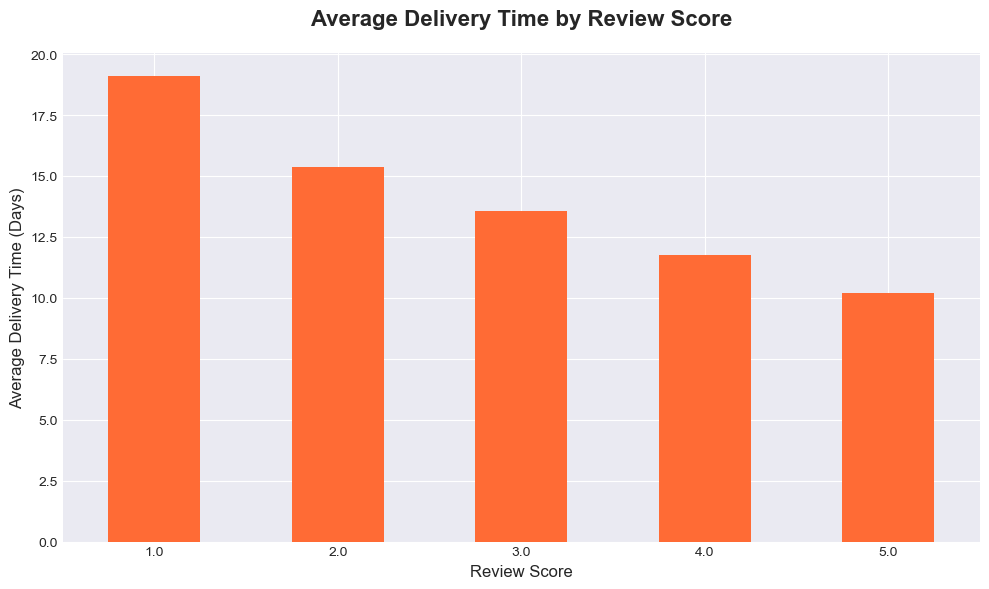


--- Correlation: Delivery Time vs Review Score ---
Correlation coefficient: -0.303


In [44]:
# Review score vs delivery performance
review_delivery = df[df['review_score'].notna() & df['delivery_time_days'].notna()].copy()
review_delivery_grouped = review_delivery.groupby('review_score')['delivery_time_days'].mean()

plt.figure(figsize=(10, 6))
review_delivery_grouped.plot(kind='bar', color='#FF6B35')
plt.title('Average Delivery Time by Review Score', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Average Delivery Time (Days)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(images_folder,'delivery_vs_review.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n--- Correlation: Delivery Time vs Review Score ---")
correlation = review_delivery[['delivery_time_days', 'review_score']].corr().iloc[0, 1]
print(f"Correlation coefficient: {correlation:.3f}")

### 10. KEY BUSINESS INSIGHTS

In [45]:
print("\n" + "="*80)
print("KEY BUSINESS INSIGHTS")
print("="*80)

# Insight 1: Revenue concentration
top_20_categories = df.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(20).sum()
total_revenue = df['price'].sum()
print(f"\n1. TOP CATEGORIES DOMINANCE")
print(f"   => Top 20 categories contribute {top_20_categories/total_revenue*100:.1f}% of total revenue")

# Insight 2: Customer retention
repeat_rate = (customer_orders['order_count'] > 1).sum() / len(customer_orders) * 100
print(f"\n2. CUSTOMER RETENTION CHALLENGE")
print(f"   => Only {repeat_rate:.1f}% of customers make repeat purchases")
print(f"   => {100-repeat_rate:.1f}% are one-time buyers - major opportunity for retention campaigns")

# Insight 3: Delivery performance
delayed_pct = delayed/len(delay_data)*100
print(f"\n3. DELIVERY PERFORMANCE")
print(f"   => {delayed_pct:.1f}% of orders are delivered late")
print(f"   => Late deliveries strongly correlate with lower review scores")

# Insight 4: Payment preferences
dominant_payment = payment_revenue.index[0]
print(f"\n4. PAYMENT PREFERENCES")
print(f"   => {dominant_payment.title()} is the dominant payment method")
print(f"   => Accounts for {payment_revenue.iloc[0]/payment_revenue.sum()*100:.1f}% of total revenue")

# Insight 5: Geographic concentration
top_3_states = state_customers.head(3)
print(f"\n5. GEOGRAPHIC CONCENTRATION")
print(f"   => Top 3 states account for significant customer base:")
for state, count in top_3_states.items():
    print(f"      - {state}: {count:,} customers")

# Insight 6: Order timing
hourly_orders = df.groupby('order_hour')['order_id'].nunique()
peak_hour = hourly_orders.idxmax()
print(f"\n6. PEAK ORDERING TIME")
print(f"   => Most orders placed at {peak_hour}:00 hours")


KEY BUSINESS INSIGHTS

1. TOP CATEGORIES DOMINANCE
   => Top 20 categories contribute 84.0% of total revenue

2. CUSTOMER RETENTION CHALLENGE
   => Only 3.0% of customers make repeat purchases
   => 97.0% are one-time buyers - major opportunity for retention campaigns

3. DELIVERY PERFORMANCE
   => 6.8% of orders are delivered late
   => Late deliveries strongly correlate with lower review scores

4. PAYMENT PREFERENCES
   => Credit_Card is the dominant payment method
   => Accounts for 77.2% of total revenue

5. GEOGRAPHIC CONCENTRATION
   => Top 3 states account for significant customer base:
      - SP: 40,965 customers
      - RJ: 12,671 customers
      - MG: 11,456 customers

6. PEAK ORDERING TIME
   => Most orders placed at 16:00 hours


### 11. RECOMMENDATIONS

In [46]:
print("\n" + "="*80)
print("BUSINESS RECOMMENDATIONS")
print("="*80)

print("\n1. IMPROVE LOGISTICS IN HIGH-DELAY REGIONS")
print("   => Focus on states with highest delivery delays")
print("   => Partner with local logistics providers")
print("   => Set realistic delivery estimates")

print("\n2. CUSTOMER RETENTION STRATEGY")
print("   => Implement loyalty program for repeat purchases")
print("   => Send personalized follow-up emails after first purchase")
print("   => Offer discounts on second order")

print("\n3. OPTIMIZE INVENTORY FOR TOP CATEGORIES")
print("   => Prioritize stock for top 20 revenue-generating categories")
print("   => Analyze seasonal trends for better forecasting")

print("\n4. DELIVERY PERFORMANCE MONITORING")
print("   => Set up alerts for potential delays")
print("   => Proactive communication with customers about delays")
print("   => Incentivize faster deliveries from sellers")

print("\n5. PAYMENT OPTIONS EXPANSION")
print("   => Maintain focus on popular payment methods")
print("   => Consider emerging payment options")

print("\n6. GEOGRAPHIC EXPANSION STRATEGY")
print("   => Strengthen presence in underserved states")
print("   => Localized marketing campaigns")


BUSINESS RECOMMENDATIONS

1. IMPROVE LOGISTICS IN HIGH-DELAY REGIONS
   => Focus on states with highest delivery delays
   => Partner with local logistics providers
   => Set realistic delivery estimates

2. CUSTOMER RETENTION STRATEGY
   => Implement loyalty program for repeat purchases
   => Send personalized follow-up emails after first purchase
   => Offer discounts on second order

3. OPTIMIZE INVENTORY FOR TOP CATEGORIES
   => Prioritize stock for top 20 revenue-generating categories
   => Analyze seasonal trends for better forecasting

4. DELIVERY PERFORMANCE MONITORING
   => Set up alerts for potential delays
   => Proactive communication with customers about delays
   => Incentivize faster deliveries from sellers

5. PAYMENT OPTIONS EXPANSION
   => Maintain focus on popular payment methods
   => Consider emerging payment options

6. GEOGRAPHIC EXPANSION STRATEGY
   => Strengthen presence in underserved states
   => Localized marketing campaigns


### 12. EXPORT KEY METRICS FOR REPORTING

In [47]:
print("\n" + "="*80)
print("EXPORTING KEY METRICS")
print("="*80)

# Summary metrics
summary_metrics = {
    'Total Revenue (R$)': f"{df['price'].sum():,.2f}",
    'Total Orders': f"{df['order_id'].nunique():,}",
    'Total Customers': f"{df['customer_unique_id'].nunique():,}",
    'Average Order Value (R$)': f"{df.groupby('order_id')['price'].sum().mean():,.2f}",
    'Repeat Customer Rate (%)': f"{repeat_rate:.2f}",
    'Average Delivery Time (Days)': f"{delivery_data['delivery_time_days'].mean():.1f}",
    'On-Time Delivery Rate (%)': f"{on_time/len(delay_data)*100:.1f}",
    'Average Review Score': f"{df['review_score'].mean():.2f}"
}

summary_df = pd.DataFrame(summary_metrics.items(), columns=['Metric', 'Value'])
summary_df.to_csv(os.path.join(csv_folder,'summary_metrics.csv'), index=False)

print("\n--> Summary metrics exported to 'summary_metrics.csv'")

# Export top categories
top_categories.to_csv(os.path.join(csv_folder,'top_categories.csv'))

print("--> Top categories exported to 'top_categories.csv'")


EXPORTING KEY METRICS

--> Summary metrics exported to 'summary_metrics.csv'
--> Top categories exported to 'top_categories.csv'


In [48]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated Visualizations:")
print("  1. monthly_revenue_trend.png")
print("  2. top_categories_revenue.png")
print("  3. payment_type_revenue.png")
print("  4. purchase_frequency.png")
print("  5. top_states_customers.png")
print("  6. delivery_time_distribution.png")
print("  7. delivery_delay_by_state.png")
print("  8. delivery_vs_review.png")
print("\nExported Files:")
print("  1. summary_metrics.csv")
print("  2. top_categories.csv")
print("\n" + "="*80)


ANALYSIS COMPLETE!

Generated Visualizations:
  1. monthly_revenue_trend.png
  2. top_categories_revenue.png
  3. payment_type_revenue.png
  4. purchase_frequency.png
  5. top_states_customers.png
  6. delivery_time_distribution.png
  7. delivery_delay_by_state.png
  8. delivery_vs_review.png

Exported Files:
  1. summary_metrics.csv
  2. top_categories.csv

